In [1]:
import numpy as np
import cv2 as cv2
from matplotlib import pyplot as plt

pieces_top_view = [
    'Images/StandardView/1.jpg',
    'Images/StandardView/2.jpg',
    'Images/StandardView/3.jpg',
    'Images/StandardView/4.jpg',
    'Images/StandardView/5.jpg',
    'Images/StandardView/6.jpg',
    'Images/StandardView/7.jpg',
    'Images/StandardView/8.jpg',
    'Images/StandardView/9.jpg',
    'Images/StandardView/10.jpg',
    'Images/StandardView/11.jpg',
    'Images/StandardView/12.jpg',
    'Images/StandardView/13.jpg',
    'Images/StandardView/14.jpg',
]

img = pieces_top_view[0]

In [2]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [3]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [4]:
def show_line(img, line, color):
    arr = np.array(line[0], dtype=np.float64)
    r, theta = arr
    a = np.cos(theta)
    b = np.sin(theta)

    x0 = a*r
    y0 = b*r

    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))

    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img, (x1, y1), (x2, y2), color, 2)

In [5]:
plt.figure(figsize=(24,24))

img = cv2.imread(pieces_top_view[3])

width = 700
height = 700
dim = (width, height)

# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 150, 240, apertureSize=3)

lines = cv2.HoughLines(edges, 1, np.pi/180, 140)

segmented = segment_by_angle_kmeans(lines)

i = 0

for lines in segmented:
    print("Section " + str(i))
    
    min_val = 9999999999
    max_val = 0
    
    for line in lines:
        arr = np.array(line[0], dtype=np.float64)
        r, theta = arr
        
        a = np.cos(theta)
        b = np.sin(theta)

        x0 = a*r
        y0 = b*r
        
        if i == 0:
            v = x0
        else:
            v = y0
        if v > max_val:
            max_line = line
            max_val = r
            
        if v < min_val:
            min_line = line
            min_val = r

    show_line(img, min_line, (0, 255, 0))
    show_line(img, max_line, (255, 0, 0))
    i = i + 1

cv2.imshow('linesDetected',img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

Section 0
Section 1


<Figure size 2400x2400 with 0 Axes>

In [6]:
plt.figure(figsize=(24,24))

img = cv2.imread(pieces_top_view[7])

width = 700
height = 700
dim = (width, height)

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 1

# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 150, 240, apertureSize=3)

lines = cv2.HoughLines(edges, 1, np.pi/180, 120)

segmented = segment_by_angle_kmeans(lines)

i = 0

for lines in segmented:
    print("Section " + str(i))
    color = (0, 0, 0)

    y = 0
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr
        a = np.cos(theta)
        b = np.sin(theta)

        x0 = a*r
        y0 = b*r

        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))

        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
               
        cv2.line(img, (x1, y1), (x2, y2), color, 2)
        
       
        
        c = list(color)   
        c[i] = c[i] + 30
        color = tuple(c)
        
        print(r, theta, a, b, x0, y0)
        
        y = y + 1

    
    i = i + 1

cv2.imshow('linesDetected',img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

Section 0
460.0 1.5882495641708374 -0.017452351301679672 0.9998476961187852 -8.02808159877265 459.9299402146412
289.0 1.5707963705062866 -4.371139000186241e-08 0.999999999999999 -1.2632591710538237e-05 288.9999999999997
330.0 1.5707963705062866 -4.371139000186241e-08 0.999999999999999 -1.4424758700614596e-05 329.99999999999966
512.0 1.5882495641708374 -0.017452351301679672 0.9998476961187852 -8.935603866459992 511.92202041281803
412.0 1.5882495641708374 -0.017452351301679672 0.9998476961187852 -7.190368736292025 411.9372508009395
250.0 1.5707963705062866 -4.371139000186241e-08 0.999999999999999 -1.0927847500465603e-05 249.99999999999974
372.0 1.5707963705062866 -4.371139000186241e-08 0.999999999999999 -1.6260637080692817e-05 371.9999999999996
504.0 1.6057028770446777 -0.034899461933588664 0.9993908282332523 -17.589328814528688 503.69297742955916
535.0 1.6057028770446777 -0.034899461933588664 0.9993908282332523 -18.671212134469936 534.67409310479
180.0 1.5533430576324463 0.0174523830833

<Figure size 2400x2400 with 0 Axes>

In [7]:
plt.figure(figsize=(24,24))

img = cv2.imread(pieces_top_view[2])

width = 700
height = 700
dim = (width, height)

# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 150, 240, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi/180, 140)

segmented = segment_by_angle_kmeans(lines)

intersections = segmented_intersections(segmented)

A = np.array(intersections)
A = A.reshape((A.shape[0], A.shape[2]))

max_indexs = np.argmax(A, axis=0)
min_indexs = np.argmin(A, axis=0)

print('Max')
print(max_indexs)
print('MIN')
print(min_indexs)

print("points")
print(A[max_indexs[0]])
print(A[max_indexs[1]])
print(A[min_indexs[0]])
print(A[min_indexs[1]])


img = cv2.circle(img, (735, 592), radius=3, color=(0, 0, 255), thickness=-1)
img = cv2.circle(img, (504, 21), radius=3, color=(0, 255, 0), thickness=-1)


cv2.imshow('linesDetected',img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

Max
[0 0]
MIN
[ 5 15]
points
[594 565]
[594 565]
[ 78 556]
[108 133]


<Figure size 2400x2400 with 0 Axes>

In [8]:
# Permet de recuperer la ligne de reference pour comparer plusieurs ligne entre elle
def get_ref_line(axis, center):
    if axis == 1:
        return [[center[0], 0]]
    return [[center[1], np.pi/2]]

In [9]:
# Recuperer la ligne la plus à gauche/basse et la plus à droite/haute
def get_min_max_lines(lines, center, axis=0):
    ref_line = get_ref_line(axis, center)
    
    max_point = -99999999
    min_point = 99999999 
    
    for line in lines:
        coord = intersection(ref_line, line)
        point = coord[0][axis]

        if point > max_point:
            max_point = point
            max_line = line
        if point < min_point:
            min_point = point
            min_line = line
    
    return [min_line, max_line]

In [10]:
def get_lines_cross_points(lines, center, axis=0):
    ref_line = get_ref_line(axis, center)
    
    points = []
    
    for line in lines:
        coord = intersection(ref_line, line)
        point = coord[0][axis]
        points.append(point)
        
    return points

In [11]:
# Ne fonction pas
def keep_similar_lines(lines, tolerence):
    a = np.array(lines).reshape(len(lines), 2)
    b = a[:, 1]
    m = np.median(b, axis=0)
   
    # /!\ 0 = 180° 
    # mask = np.absolute((b - m)) < tolerence
    
    print("M", m)
    
    c = b - m
    c = (c + np.pi) % np.pi*2
    
    print("C", c)

    mask = c < tolerence
    
    filtered = []

    for i, line in enumerate(lines):
        if mask[i]:
            filtered.append(line)

    return filtered

### Test : Detecteur de Harris

In [12]:
plt.figure(figsize=(24,24))

img = cv2.imread(pieces_top_view[3])
print(img.shape)

width = 700
height = 700
dim = (width, height)
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_median = cv2.medianBlur(gray, 7)

dst = cv2.cornerHarris(img_median,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

cv2.imshow('linesDetected',img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

(4032, 3024, 3)


<Figure size 2400x2400 with 0 Axes>

In [201]:
image_id = 12
image_ref = cv2.imread(pieces_top_view[image_id])

size = 700
center = (size/2, size/2)

def resize_img(img, size = 700):
    width = size
    height = size
    dim = (width, height)

    return cv2.resize(image_ref, dim, interpolation = cv2.INTER_AREA)

image_ref = resize_img(image_ref)
print(image_ref.shape)

(700, 700, 3)


In [209]:
def get_max_contour(contours):
    max_find = 0

    for cnt in contours:        
        rect = cv2.minAreaRect(cnt)       #I have used min Area rect for better result
        width = rect[1][0]
        height = rect[1][1]

        area = width * height

        if area > max_find:
            max_find = area
            max_cnt = cnt
            
    return max_cnt

In [210]:
def get_cropped_img_from_max_contour(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    img_median = cv2.medianBlur(gray, 7)
    img_median = cv2.dilate(img_median, None, iterations = 3)
    img_median = cv2.erode(img_median, None, iterations = 3)

    ret,threshold_img = cv2.threshold(img_median,100,255,cv2.THRESH_BINARY) # valeur à choisir avec precaution
    threshold_img = cv2.bitwise_not(threshold_img)
    threshold_img = cv2.dilate(threshold_img, None, iterations = 2)
    threshold_img = cv2.medianBlur(threshold_img, 9)

    contours, hierarchy = cv2.findContours(threshold_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_cnt = get_max_contour(contours)

    x, y, w, h = cv2.boundingRect(max_cnt)


    cropped_img_ref = img[y:y+h, x:x+w]
    cropped_values = (x,y,w,h)
    cropped_center = (int(w/2),int(h/2))
    
    return (cropped_img_ref, cropped_values, cropped_center)
    

# Debut du traitement

In [269]:
image_id = 2
image_ref = cv2.imread(pieces_top_view[image_id])

size = 700
center = (size/2, size/2)

width = size
height = size
dim = (width, height)

# resize image
image_ref = cv2.resize(image_ref, dim, interpolation = cv2.INTER_AREA)
print(image_ref.shape)

(700, 700, 3)


In [270]:
cv2.imshow('Image',image_ref)
cv2.waitKey(0)

-1

## Detecteur de contour

In [271]:
img = image_ref.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

img_median = cv2.medianBlur(gray, 7)
img_median = cv2.dilate(img_median, None, iterations = 3)
img_median = cv2.erode(img_median, None, iterations = 3)

ret,threshold_img = cv2.threshold(img_median,100,255,cv2.THRESH_BINARY) # valeur à choisir avec precaution
threshold_img = cv2.bitwise_not(threshold_img)
threshold_img = cv2.dilate(threshold_img, None, iterations = 2)
threshold_img = cv2.medianBlur(threshold_img, 9)

contours, hierarchy = cv2.findContours(threshold_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

max_find = 0

for cnt in contours:        
    rect = cv2.minAreaRect(cnt)       #I have used min Area rect for better result
    width = rect[1][0]
    height = rect[1][1]
    
    area = width * height
    
    if area > max_find:
        max_find = area
        max_cnt = cnt
        
x, y, w, h = cv2.boundingRect(max_cnt)


cropped_values = (x,y,w,h)
        
cropped_img_ref = img[y:y+h, x:x+w]
cropped_center = (int(w/2),int(h/2))

In [272]:
img = image_ref.copy()

cropped_img_ref, cropped_values, cropped_center = get_cropped_img_from_max_contour(img)

In [273]:
a = threshold_img.copy()

cv2.imshow('a',a)
cv2.waitKey(0)

-1

## Detection des lignes de l'image avec mask

In [292]:
def get_segmented_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 150, 240, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 120)

    return segment_by_angle_kmeans(lines)

In [295]:
cropped_img = cropped_img_ref.copy()

# Recuperation des lignes gauche, droite, haute, basse du plateau

segmented = get_segmented_lines(cropped_img)

i_lines = segmented[0]
j_lines = segmented[1]

# On utilise les points de croisements de toute les lignes sur une lignes de reference pour trouver la premiere et la derniere
# 2 lignes paralleles => erreur
# Si erreur, on inverse l'axe de reference
try:
    min_max_i_line = get_min_max_lines(i_lines, cropped_center, axis=1) # on inverse 0 et 1 si erreur (2 lignes paralleles)
    min_max_j_line = get_min_max_lines(j_lines, cropped_center, axis=0)
except:
    min_max_i_line = get_min_max_lines(i_lines, cropped_center, axis=0)
    min_max_j_line = get_min_max_lines(j_lines, cropped_center, axis=1)
    
    
intersections = np.array(segmented_intersections([min_max_i_line, min_max_j_line]))


print(intersections)

[[[ 24  23]]

 [[ -2 399]]

 [[505  32]]

 [[511 399]]]


## Show all line detected

In [296]:
cropped_img_copy = cropped_img_ref.copy()

print(cropped_img_copy.shape)

for line in v_lines:
    show_line(cropped_img_copy, line, (255, 0, 0))
for line in h_lines:
    show_line(cropped_img_copy, line, (0, 0, 255))

cv2.imshow('linesDetected',cropped_img_copy)
cv2.waitKey(0)

(403, 524, 3)


-1

In [297]:
line = get_ref_line(1, cropped_center)
line_2 = get_ref_line(0, cropped_center)

print(cropped_center)

cropped_img_copy = cropped_img_ref.copy()

show_line(cropped_img_copy, line, (255, 0, 255))
show_line(cropped_img_copy, line_2, (255, 0, 0))

cv2.imshow('linesDetected',cropped_img_copy)
cv2.waitKey(0)

(262, 201)


-1

## Show intersections

In [298]:
cropped_img_copy = cropped_img_ref.copy()

cropped_img_copy = cv2.circle(cropped_img_copy, tuple(*intersections[0]), radius=5, color=(0, 255, 0), thickness=-1)
cropped_img_copy = cv2.circle(cropped_img_copy, tuple(*intersections[1]), radius=5, color=(0, 0, 255), thickness=-1)
cropped_img_copy = cv2.circle(cropped_img_copy, tuple(*intersections[2]), radius=5, color=(0, 0, 0), thickness=-1)
cropped_img_copy = cv2.circle(cropped_img_copy, tuple(*intersections[3]), radius=5, color=(0, 255, 255), thickness=-1)

cv2.imshow('linesDetected',cropped_img_copy)
cv2.waitKey(0)

-1

In [299]:
print(size)

700


# Find and create Homography img

In [278]:
#cropped_img = cropped_img_ref.copy()

# Changement de l'Homographie pour l'appliquer sur l'image de reference

img = image_ref.copy()

x, y, h, w = cropped_values
intersections_img_ref = intersections + (x, y)

print(x, y)
print("intersections", intersections)
print("intersections_img_ref", intersections_img_ref)



src = np.array(intersections_img_ref)
dst = np.array([[0,0],[size,0],[0,size],[size,size]])

print("SRC", src)
print("DST", dst)

h, status = cv2.findHomography(src, dst);
im_dst = cv2.warpPerspective(img, h, (size,size))

82 134
intersections [[[ 24  23]]

 [[ -2 399]]

 [[505  32]]

 [[511 399]]]
intersections_img_ref [[[106 157]]

 [[ 80 533]]

 [[587 166]]

 [[593 533]]]
SRC [[[106 157]]

 [[ 80 533]]

 [[587 166]]

 [[593 533]]]
DST [[  0   0]
 [700   0]
 [  0 700]
 [700 700]]


In [279]:
cv2.imshow('Homographie',im_dst)
cv2.waitKey(0)

-1

In [280]:
gray = cv2.cvtColor(im_dst, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 150, 240, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi/180, 110)

# Recuperation des lignes gauche, droite, haute, basse du plateau

segmented = segment_by_angle_kmeans(lines)

v_lines = segmented[0]
h_lines = segmented[1]

In [281]:
def mean_similar_points(points, tolerence):
    next_group_id = 0
    keys_groups = dict()

    for i, value in enumerate(points): 
        mask = np.absolute(points-value) < tolerence
        similars = points[mask]
        if value in keys_groups:
            for s in similars:
                keys_groups[s] = keys_groups[value]
        else:
            for s in similars:
                keys_groups[s] = next_group_id
            next_group_id = next_group_id + 1

    inv_map = {}
    for k, v in keys_groups.items():
        inv_map[v] = inv_map.get(v, []) + [k]

    mean_points = []
    for i in inv_map:
        i_list = inv_map[i]
        i_mean = int(sum(i_list) / len(i_list))
        mean_points.append(i_mean)

    return mean_points

In [282]:
im_dst_copy = im_dst.copy()

In [283]:
for i in v_lines:
    show_line(im_dst_copy, i, (0, 255, 0))

for i in h_lines:
    show_line(im_dst_copy, i, (0, 0, 255))   

In [284]:
cv2.imshow('im_dst',im_dst_copy)
cv2.waitKey(0)

-1

In [285]:
# =====================
# L'objectif de ce code est d'aller chercher la meilleur premiere ligne de l'echiquier
# Pour cela, on calcule deja l'ecart median pour determiner la taille d'une case
# Puis on vient avec different calcule determiné combien de case peuvent être contenu entre 2 lignes en partant d'un
# point de départ "s"
# L'objectif est de maximiser ce nombre de case

def find_cases_between_points(points, tolerance=.1):
    points = np.sort(points)
    departs = points.copy()
    max_p = np.max(points)

    # On defini le depart sur le point 0
    s = 0
    points = np.insert(points, 0, s)
    
    print(points)

    max_s_find = -1
    max_ect_norm_divisor = np.array([])
    first_point_idx = 0
    
    idx = 0

    while s < max_p:
        
        print("S :", s)

        rlt_points = points - s
        rlt_points = rlt_points[rlt_points >= 0]

        # Si il n'y a plus de point dans la zone de recherche, on arrete la recherche
        if rlt_points.shape[0] == 0:
            break


        print("rlt_points", rlt_points)
        print("rlt_points roll", np.roll(rlt_points, 1))

        rlt_points_ect = rlt_points - np.roll(rlt_points, 1)

        # On supprime la premiere colonne qui n'est pas utile
        rlt_points_ect = rlt_points_ect[1:]

        print("rlt_points_ect", rlt_points_ect)

        # On recuperer la distance median entre 2 lignes (on considera cette distance comme la taille d'une case)
        ect_median = np.median(rlt_points_ect)
        print("ect_median", ect_median)

        # On normalise nos distances sur la base de la taille d'une case
        ect_norm = np.divide(rlt_points_ect, ect_median)

        print("ect_norm", ect_norm)

        # On vient recuperer le reste de la division par 1 de nos distances normaliser
        ect_norm_rst = np.abs((ect_norm % 1)) 
        # Puis on utilise ce reste pour connaire le nombre de case presente entre 2 lignes
        ect_norm_divisor = (ect_norm - ect_norm_rst).astype(int)

        print("ect_norm_rst", ect_norm_rst)
        print("ect_norm_divisor", ect_norm_divisor)

        # Certaine case peuvent être legrement plus petite que 1 mais existe quand même
        # On compabilise une case si elle font au moins 90% de la taile d'une case
        mask_add = ect_norm_rst >= (1 - tolerance)
        ect_norm_divisor[mask_add] = ect_norm_divisor[mask_add] + 1 
        
        
        # Certain element peuvent contenir 1 case et une parti d'une autre, ce qui n'est pas valide dans notre cas
        mask_remove = (ect_norm_rst < (1 - tolerance)) & (ect_norm_rst > tolerance)
        ect_norm_divisor[mask_remove] = 0
        
        print("mask_remove", mask_remove)
        

        print("ect_norm_divisor with added case", ect_norm_divisor)

        # =============================
        # On vient comparer notre resultat avec les prevedents

        if np.sum(max_ect_norm_divisor) <= np.sum(ect_norm_divisor):
            max_s_find = s
            max_ect_norm_divisor = ect_norm_divisor
            first_point_idx = idx

        # =============================
        # Optimisation : Si toutes les zones entre 2 lignes contiennent au moins une case, on s'arrete
        if ect_norm_divisor[ect_norm_divisor == 0].shape[0] == 0:
            break

        # =============================
        # Changement du point de depart

        # Si il n'y a plus d'autre point de depart, on arrete la recherche
        if (departs[0] is None):
            break;

        # Sinon, on chnage le point de depart
        s = departs[0]
        departs = departs[1:]

        idx = idx + 1
        
    return (
        max_s_find,
        max_ect_norm_divisor,
        first_point_idx
    )

In [286]:
# =====================
# Ce code permet de calculer les coordonnées de l'echiquier
#

def get_interpolate_coord(points):
    points = np.sort(points)
    max_s_find, max_ect_norm_divisor, first_point_idx = find_cases_between_points(points)

    coord = [max_s_find]
    
    print("---- get_interpolate_coord ----")

    for i, nbr_case in enumerate(max_ect_norm_divisor):
        print("Nbr de case :", nbr_case, "Idx :", i)

        if nbr_case == 0:
            continue

        current_idx = first_point_idx + i
        current_point = points[current_idx]

        print("current_idx", current_idx)
        print("current_point", current_point)

        if nbr_case == 1:
            coord.append(current_point)
        else:
            for j in range(1,nbr_case+1):
                factor = j / nbr_case
                print(factor)

                previous_point = points[current_idx - 1]
                distance = current_point - previous_point

                print("previous_point", previous_point)
                print("distance", distance)

                interpolate_point = previous_point + distance*factor

                coord.append(interpolate_point)


    return np.array(coord).astype(int)

In [287]:
try:
    v_points = np.array(get_lines_cross_points(v_lines, center, axis=0))
    h_points = np.array(get_lines_cross_points(h_lines, center, axis=1))
except:
    v_points = np.array(get_lines_cross_points(h_lines, center, axis=0))
    h_points = np.array(get_lines_cross_points(v_lines, center, axis=1))

im_dst_w = im_dst_copy.shape[0]
im_dst_h = im_dst_copy.shape[1]
    
    
v_points = np.insert(v_points, len(v_points), im_dst_w)
h_points = np.insert(h_points, len(h_points), im_dst_h)

v_points = v_points[(v_points <= im_dst_w) & (v_points >= 0)]
h_points = h_points[(h_points <= im_dst_h) & (h_points >= 0)]

v_points = mean_similar_points(v_points, 30)
h_points = mean_similar_points(h_points, 30)

print(v_points)
print(h_points)

print("===== Vertical =====")
v_coord = get_interpolate_coord(v_points)

print("===== Horizontal =====")
h_coord = get_interpolate_coord(h_points)

print(v_coord)
print(h_coord)

for p in v_coord:
    im_dst_copy = cv2.circle(im_dst_copy, tuple([int(p), 10]), radius=5, color=(255, 0, 0), thickness=-1)

for p in h_coord:
    im_dst_copy = cv2.circle(im_dst_copy, tuple([10, int(p)]), radius=5, color=(0, 0, 255), thickness=-1)
    

[267, 179, 92, 352, 437, 525, 612, 3, 699]
[3, 432, 345, 89, 175, 519, 262, 606, 698]
===== Vertical =====
[  0   3  92 179 267 352 437 525 612 699]
S : 0
rlt_points [  0   3  92 179 267 352 437 525 612 699]
rlt_points roll [699   0   3  92 179 267 352 437 525 612]
rlt_points_ect [ 3 89 87 88 85 85 88 87 87]
ect_median 87.0
ect_norm [0.03448276 1.02298851 1.         1.01149425 0.97701149 0.97701149
 1.01149425 1.         1.        ]
ect_norm_rst [0.03448276 0.02298851 0.         0.01149425 0.97701149 0.97701149
 0.01149425 0.         0.        ]
ect_norm_divisor [0 1 1 1 0 0 1 1 1]
mask_remove [False False False False False False False False False]
ect_norm_divisor with added case [0 1 1 1 1 1 1 1 1]
S : 3
rlt_points [  0  89 176 264 349 434 522 609 696]
rlt_points roll [696   0  89 176 264 349 434 522 609]
rlt_points_ect [89 87 88 85 85 88 87 87]
ect_median 87.0
ect_norm [1.02298851 1.         1.01149425 0.97701149 0.97701149 1.01149425
 1.         1.        ]
ect_norm_rst [0.02298851

In [288]:
im_dst_copy = im_dst.copy()

min_x = np.min(v_coord)
min_y = np.min(h_coord)
max_x = np.max(v_coord)
max_y = np.max(h_coord)

print(min_x, min_y)
print(max_x, max_y)

final_x_coords = v_coord - min_x
final_y_coords = h_coord - min_y

final_chess_plate_ref = im_dst_copy[min_y:max_y, min_x:max_x]                                    

print(final_chess_plate_ref.shape)
print(final_x_coords, final_y_coords)

3 3
699 698
(695, 696, 3)
[  0  89 176 264 349 434 522 609 696] [  0  86 172 259 342 429 516 603 695]


In [289]:
class ChessPlate:
    
    def __init__(self, plate_img, x_coords, y_coords):
        self.plate_img = plate_img
        self.x_coords = x_coords
        self.y_coords = y_coords
        
    def get_chess_plate_img(self):
        return self.plate_img.copy()
    
    def show(self):
        final_chess_plate = self.get_chess_plate_img()

        for i in self.x_coords:
            show_line(final_chess_plate, [[i, 0]], (0, 255, 0))

        for i in self.y_coords:
            show_line(final_chess_plate, [[i, np.pi/2]], (0, 0, 255))
            
        cv2.imshow('chess board',final_chess_plate)
        cv2.waitKey(0)
        
    def get_case(self, i,j):
        
        x1 = self.x_coords[i]
        x2 = self.x_coords[i+1]
        y1 = self.y_coords[j]
        y2 = self.y_coords[j+1]
        
        return self.plate_img[x1:x2, y1:y2]

In [290]:
chess_plate = ChessPlate(final_chess_plate_ref, final_x_coords, final_y_coords)
chess_plate.show()

In [252]:
chess_plate_img = chess_plate.get_chess_plate_img()

gray = cv2.cvtColor(chess_plate_img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 240, apertureSize=3)


cv2.imshow('chess board',edges)
cv2.waitKey(0)

-1

In [300]:
sob_8u = cv2.Sobel(chess_plate_img,cv2.CV_8U,1,0,ksize=3)

sobel_64 = cv2.Sobel(chess_plate_img,cv2.CV_64F,1,0,ksize=3)
abs_64 = np.absolute(sobel_64)
sobel_8u = np.uint8(abs_64)

cv2.imshow('a',sob_8u)
cv2.imshow('a1',sobel_8u)
cv2.waitKey(0)

-1

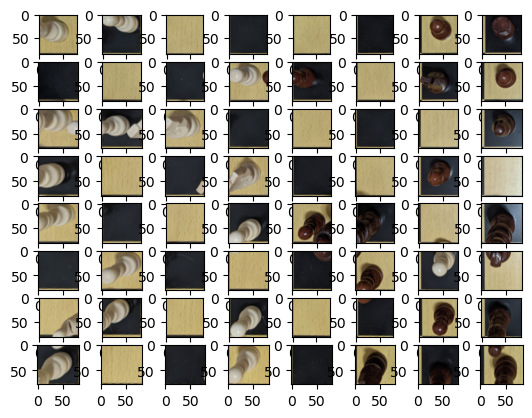

In [176]:
fig, ax = plt.subplots(8, 8)

for i in range(0,8):
    for j in range(0,8):
        case = chess_plate.get_case(i,j)
        ax[i,j].imshow(case[:,:,::-1],cmap = 'gray')

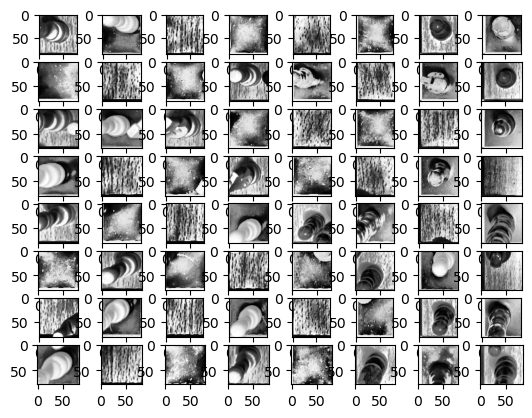

In [177]:
fig, ax = plt.subplots(8, 8)

for i in range(0,8):
    for j in range(0,8):
        case = chess_plate.get_case(i,j)
        gray_case = cv2.cvtColor(case, cv2.COLOR_BGR2GRAY)
        equ_case = cv2.equalizeHist(gray_case)
        ax[i,j].imshow(equ_case,cmap = 'gray')

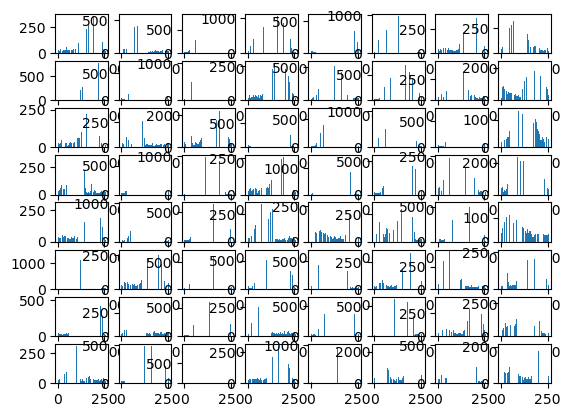

In [178]:
fig, ax = plt.subplots(8, 8)

for i in range(0,8):
    for j in range(0,8):
        case = chess_plate.get_case(i,j)
        gray_case = cv2.cvtColor(case, cv2.COLOR_BGR2GRAY)
        equ_case = cv2.equalizeHist(gray_case)
        ax[i,j].hist(equ_case.ravel(),256,[0,256]);

In [ ]:
def get_chess_plate(img):
    
    